# Project Summary
This dashboard provides an interactive exploration of COVID-19 vaccination progress across countries worldwide. By visualizing daily vaccinations per million people, it offers valuable insights into how different nations are managing their vaccination campaigns over time. The interactive dropdown allows users to easily compare vaccination trends country by country, highlighting disparities and progress in vaccine rollout efforts. Overall, this tool aims to make complex vaccination data accessible and understandable, supporting informed discussions about global public health responses to the pandemic.

In [54]:
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [13]:
import pandas as pd
df = pd.read_csv('country_vaccinations.csv')
import ipywidgets as widgets

## Exploratory Data Analysis (EDA)
Begin with basic checks:

In [14]:
df.shape, df.info(), df.describe(), df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86512 entries, 0 to 86511
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              86512 non-null  object 
 1   iso_code                             86512 non-null  object 
 2   date                                 86512 non-null  object 
 3   total_vaccinations                   43607 non-null  float64
 4   people_vaccinated                    41294 non-null  float64
 5   people_fully_vaccinated              38802 non-null  float64
 6   daily_vaccinations_raw               35362 non-null  float64
 7   daily_vaccinations                   86213 non-null  float64
 8   total_vaccinations_per_hundred       43607 non-null  float64
 9   people_vaccinated_per_hundred        41294 non-null  float64
 10  people_fully_vaccinated_per_hundred  38802 non-null  float64
 11  daily_vaccinations_per_milli

((86512, 15),
 None,
        total_vaccinations  people_vaccinated  people_fully_vaccinated  \
 count        4.360700e+04       4.129400e+04             3.880200e+04   
 mean         4.592964e+07       1.770508e+07             1.413830e+07   
 std          2.246004e+08       7.078731e+07             5.713920e+07   
 min          0.000000e+00       0.000000e+00             1.000000e+00   
 25%          5.264100e+05       3.494642e+05             2.439622e+05   
 50%          3.590096e+06       2.187310e+06             1.722140e+06   
 75%          1.701230e+07       9.152520e+06             7.559870e+06   
 max          3.263129e+09       1.275541e+09             1.240777e+09   
 
        daily_vaccinations_raw  daily_vaccinations  \
 count            3.536200e+04        8.621300e+04   
 mean             2.705996e+05        1.313055e+05   
 std              1.212427e+06        7.682388e+05   
 min              0.000000e+00        0.000000e+00   
 25%              4.668000e+03        9.0

## Handle Missing Data
Before visualization, deal with missing values in important columns.

In [15]:
# Fill numeric NaNs with 0 (simple approach; for better accuracy, consider interpolation or forward fill)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill categorical/text NaNs with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

## Convert Date Column
Most visualizations need a datetime format.

In [16]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

## Create a Latest Snapshot per Country

In [17]:
latest = df.sort_values('date').groupby('country', as_index=False).last()

## Global Vaccination Trend

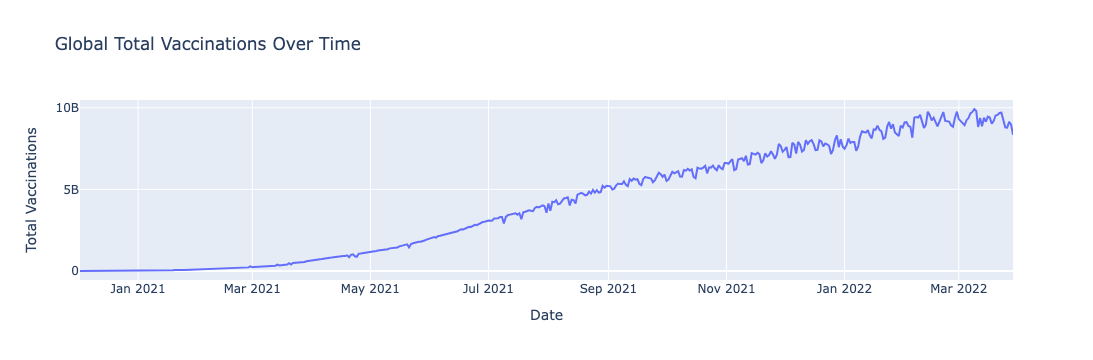

In [18]:
import plotly.express as px

global_ts = df.groupby('date', as_index=False)['total_vaccinations'].sum()
fig = px.line(global_ts, x='date', y='total_vaccinations',
              title='Global Total Vaccinations Over Time',
              labels={'total_vaccinations': 'Total Vaccinations', 'date': 'Date'})
fig.show()


## Top 10 Countries by Total Vaccinations

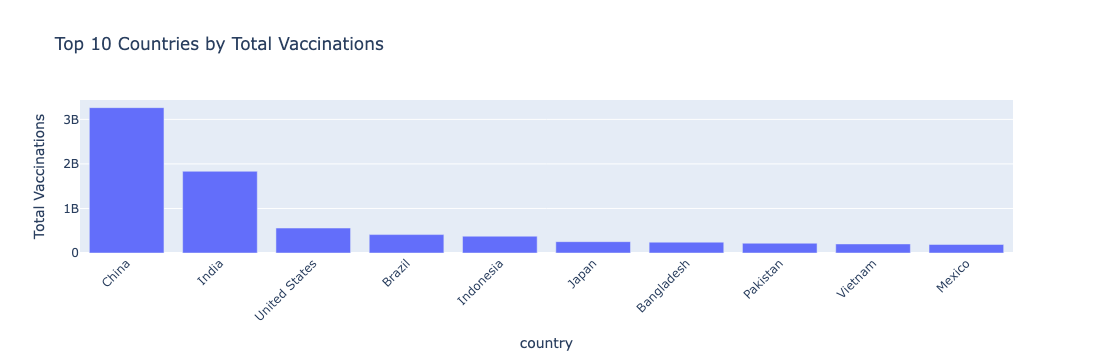

In [19]:
rank = latest.sort_values('total_vaccinations', ascending=False).head(10)
fig = px.bar(rank, x='country', y='total_vaccinations',
             title='Top 10 Countries by Total Vaccinations',
             labels={'total_vaccinations': 'Total Vaccinations'})
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## Interactive Daily Vaccinations per Country

In [20]:
from ipywidgets import interact, Dropdown
import plotly.express as px

# Sorted list of unique countries
countries = sorted(df['country'].dropna().unique())

@interact(country=Dropdown(options=countries, value=countries[0], description='Country'))
def plot_daily(country):
    # Filter and sort data
    sub = df[df['country'] == country].sort_values('date')

    if sub.empty:
        print("No data for selected country.")
        return

    # Check if column exists
    if 'daily_vaccinations_per_million' not in sub.columns:
        print("Column 'daily_vaccinations_per_million' not found.")
        return

    # Plot
    fig = px.line(sub,
                  x='date',
                  y='daily_vaccinations_per_million',
                  title=f'Daily Vaccinations per Million — {country}',
                  labels={'daily_vaccinations_per_million': 'Daily Vaccinations per Million'})
    fig.show()

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

## Choropleth Map of Fully Vaccinated People

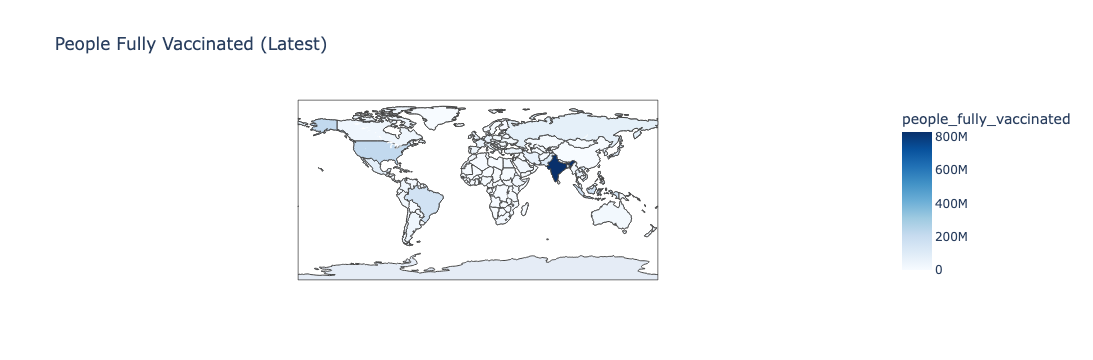

In [21]:
fig = px.choropleth(latest,
                    locations='iso_code',
                    color='people_fully_vaccinated',
                    hover_name='country',
                    title='People Fully Vaccinated (Latest)',
                    color_continuous_scale='Blues')
fig.show()